## **Programming for Data Analysis Assignment 2**

***

## **Table of Contents**

## **Introduction**

In [22]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import sys
from sklearn.impute import SimpleImputer
import random
from plotly.offline import iplot
from plotnine import ggplot, aes, geom_line, geom_bar, geom_point, labs, coord_flip, theme_xkcd, geom_smooth
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Rainfall in Ireland

In [2]:
rainfall_ireland = pd.read_csv('CSV Files/rainfall_ireland.csv', dtype={'year': int})

In [3]:
rainfall_ireland.head()

,Year,Month,Rainfall
0,1711,1,16.4
1,1711,2,73.1
2,1711,3,121.2
3,1711,4,85.2
4,1711,5,66.6


In [4]:
# Sort the dataset per month and year
rainfall_ireland = rainfall_ireland.sort_values(['Month', 'Year'])
rainfall_ireland = rainfall_ireland.reset_index().drop(['index'], axis=1)
rainfall_ireland.head()

,Year,Month,Rainfall
0,1711,1,16.4
1,1712,1,42.6
2,1713,1,97.3
3,1714,1,42.4
4,1715,1,125.8


In [5]:
mean_years = []
std_dict = {}
for m in range(1,13):
  #Calcule mu and std values
  mu = rainfall_ireland[rainfall_ireland.Month == m]['Rainfall'].mean()
  std = rainfall_ireland[rainfall_ireland.Month == m]['Rainfall'].std()
  #Save mu and std values
  mean_years.append(mu)
  std_dict[m] = std

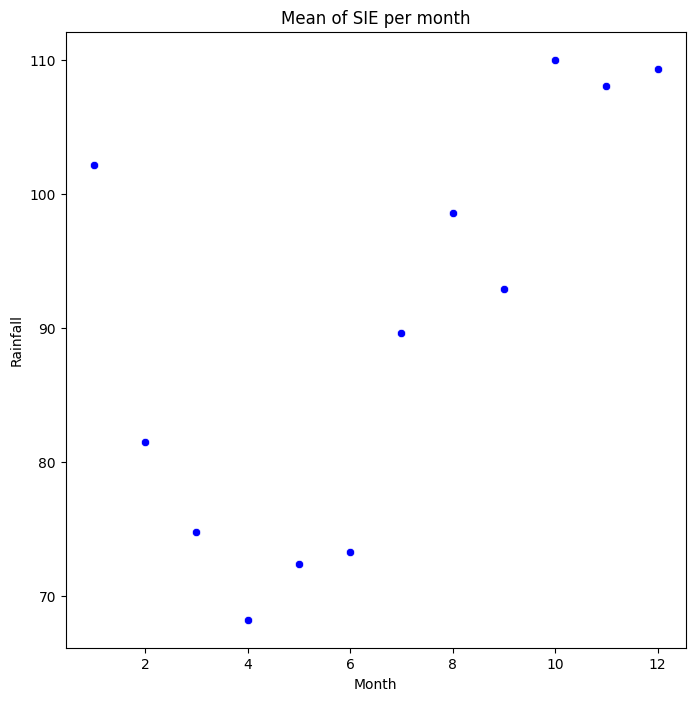

In [23]:
df_mean_years = pd.DataFrame(mean_years)
df_mean_years['Month'] = range(1, 13)
df_mean_years.columns = ['Rainfall', 'Month']
plt.figure(figsize=(8, 8))
sns.scatterplot(x='Month', y='Rainfall', data=df_mean_years,  color='blue', sizes=20).set(title='Mean of SIE per month')
plt.show()

In [7]:
ireland_rainfall_mean = []
std_dict = {}
for y in range(1711, 2016):
  #Calcule mu and std values
  mu = rainfall_ireland[rainfall_ireland.Year == y]['Rainfall'].mean()
  std = rainfall_ireland[rainfall_ireland.Year == y]['Rainfall'].std()
  #Save mu and std values
  ireland_rainfall_mean.append(mu)
  std_dict[y] = std

In [8]:
#Compute Rainfall anomalies
def anomaliesSIE(rainfall_ireland):
  #Calcule mean by months from 1981-2010
  df_300y = rainfall_ireland.query('1711 <= Year <= 2016')
  df_300y = df_300y.reset_index().drop(['index'], axis=1)
  mean_300y = []
  for m in range(1,13):
    mu = rainfall_ireland[rainfall_ireland.Month == m]['Rainfall'].mean()
    mean_300y.append(mu)

  #Compute SIE anomalies
  anomalies_list = []
  for s in range(0, len(rainfall_ireland)):
    mean_300y_index = rainfall_ireland.loc[s, 'Month']-1
    #Calcule anomalies
    anomalies_SIE = rainfall_ireland.loc[s, 'Rainfall'] - mean_300y[mean_300y_index]
    anomalies_SIE = anomalies_SIE/mean_300y[mean_300y_index]*100
    #Save anomalies
    anomalies_list.append(anomalies_SIE)
  rainfall_ireland['AnomaliesSIE'] = anomalies_list
  return rainfall_ireland, mean_300y

df_SIE, mean_300y = anomaliesSIE(rainfall_ireland)
df_SIE.head()

,Year,Month,Rainfall,AnomaliesSIE
0,1711,1,16.4,-83.947182
1,1712,1,42.6,-58.301825
2,1713,1,97.3,-4.759803
3,1714,1,42.4,-58.497591
4,1715,1,125.8,23.136864


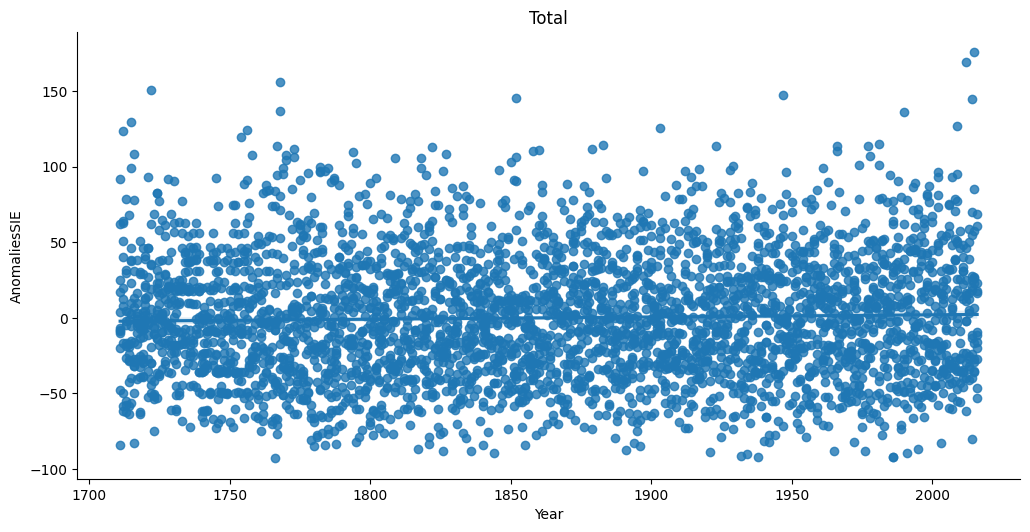

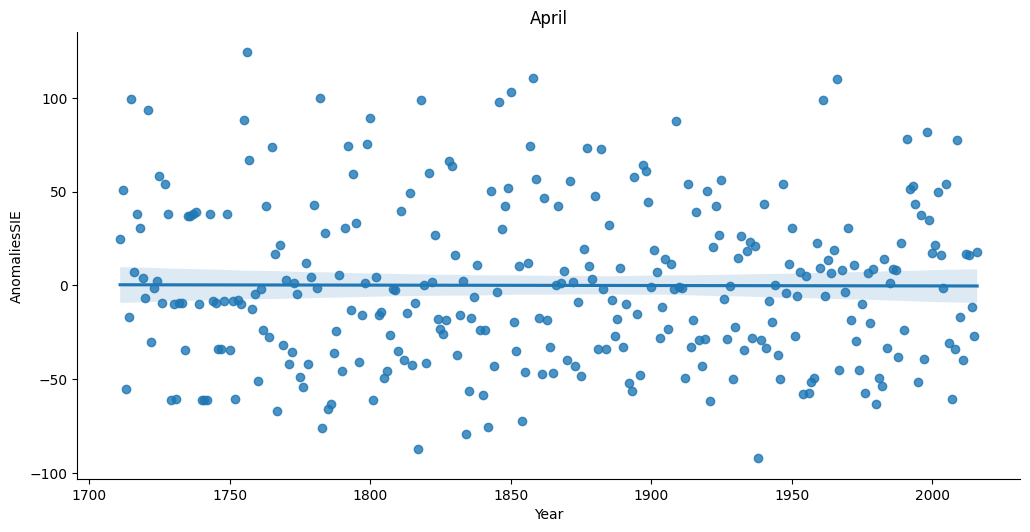

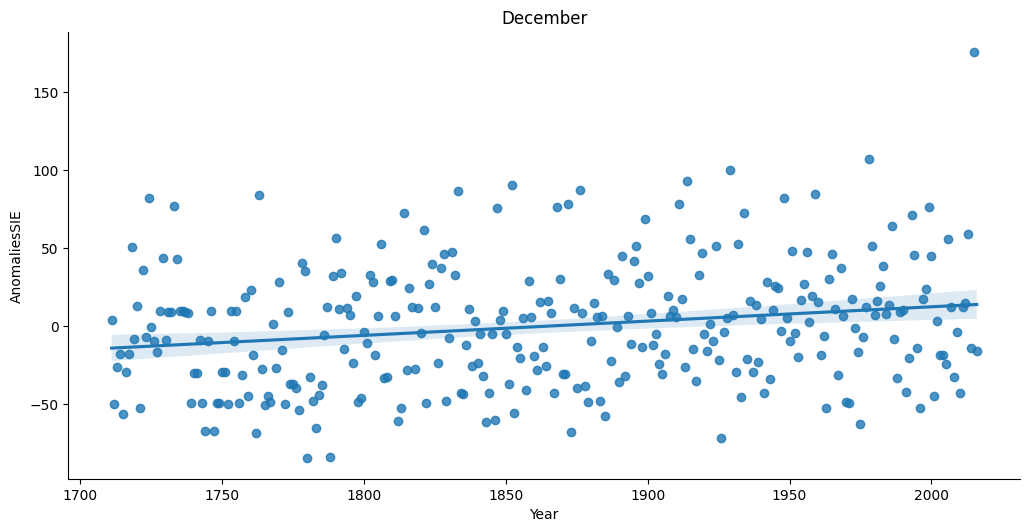

In [9]:
df_SIE['Year'] = pd.to_numeric(df_SIE['Year'])
#Total
sns.lmplot(x='Year', y='AnomaliesSIE', data=df_SIE, height=5.2, aspect=2).set(title='Total')
plt.show()
#April
sns.lmplot(x='Year', y='AnomaliesSIE', data=df_SIE[df_SIE.Month == 4], height=5.2, aspect=2).set(title='April')
plt.show()
#December
sns.lmplot(x='Year', y='AnomaliesSIE', data=df_SIE[df_SIE.Month == 12], height=5.2, aspect=2).set(title='December')
plt.show()

### Temperature in Ireland

In [10]:
west_ireland_temp = pd.read_csv('CSV Files/NUI-Galway_1851-1965.csv', encoding='ISO-8859-1',dtype={'year': int})
east_ireland_temp = pd.read_csv('CSV Files\Trinity-College-Dublin_1840-1959.csv', encoding='ISO-8859-1',dtype={'year': int})

west_ireland_temp = west_ireland_temp[['year', 'max_temp']]
east_ireland_temp = east_ireland_temp[['year', 'max_temp']]

In [11]:
malin_temp1 = pd.read_csv('CSV Files\Malin-Head_1885-1920.csv', encoding='ISO-8859-1',dtype={'year': int})
malin_temp2 = pd.read_csv('CSV Files\Malin-Head_1921-1955-data.csv', encoding='ISO-8859-1',dtype={'year': int})

In [12]:
malin_temp1 = malin_temp1[['year', 'max_temp']]
malin_temp2 = malin_temp2[['year', 'max_temp']]

north_ireland_temp = pd.concat([malin_temp1, malin_temp2])
north_ireland_temp.sort_values(by=['year'], ascending=True);

In [13]:
roches_temp1 = pd.read_csv('CSV Files\Roches-Point_1872-1920.csv', encoding='ISO-8859-1',dtype={'year': int})
roches_temp2 = pd.read_csv('CSV Files\Roches-Point_1921-1956.csv', encoding='ISO-8859-1',dtype={'year': int})

In [14]:
roches_temp1 = roches_temp1[['year', 'max_temp']]
roches_temp2 = roches_temp2[['year', 'max_temp']]

south_ireland_temp = pd.concat([roches_temp1, roches_temp2])
south_ireland_temp.sort_values(by=['year'], ascending=True);

In [15]:
all_ireland_temp = pd.concat([west_ireland_temp, east_ireland_temp, north_ireland_temp, south_ireland_temp])
all_ireland_temp.sort_values(by=['year'], ascending=True);

In [16]:
ireland_temp_mean = []
std_dict = {}
for y in range(1851, 1957):
  #Calcule mu and std values
  mu = all_ireland_temp[all_ireland_temp.year == y]['max_temp'].mean()
  std = all_ireland_temp[all_ireland_temp.year == y]['max_temp'].std()
  #Save mu and std values
  ireland_temp_mean.append(mu)
  std_dict[y] = std

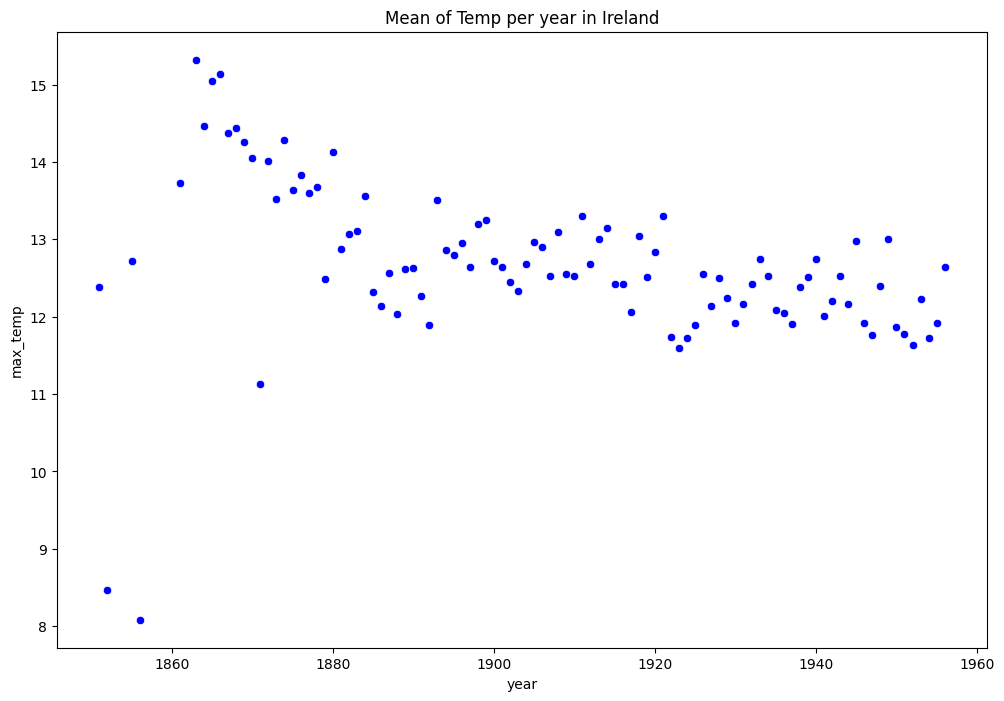

In [24]:
df_ireland_temp_mean = pd.DataFrame(ireland_temp_mean)
df_ireland_temp_mean['year'] = range(1851, 1957)
df_ireland_temp_mean.columns = ['max_temp', 'year']
plt.figure(figsize=(12, 8))
sns.scatterplot(x='year', y='max_temp', data=df_ireland_temp_mean,  color='blue', sizes=20).set(title='Mean of Temp per year in Ireland')
plt.show()

### Plotting Temperature and Rainfall in Ireland

In [58]:
years_temp = list(range(1851, 1957));

ireland_temp = pd.DataFrame({'year': years_temp, 'temp_ireland': ireland_temp_mean})
ireland_temp.temp_ireland = ireland_temp.temp_ireland.round()
ireland_temp.to_csv("ireland_temp.csv", encoding='utf-8', index=False)

years_rainfall = list(range(1711, 2016));

ireland_rainfall = pd.DataFrame({'year': years_rainfall, 'rainfall_ireland': ireland_rainfall_mean})
ireland_rainfall.rainfall_ireland = ireland_rainfall.rainfall_ireland.round(2)
ireland_rainfall.to_csv("ireland_rainfall.csv", encoding='utf-8', index=False)

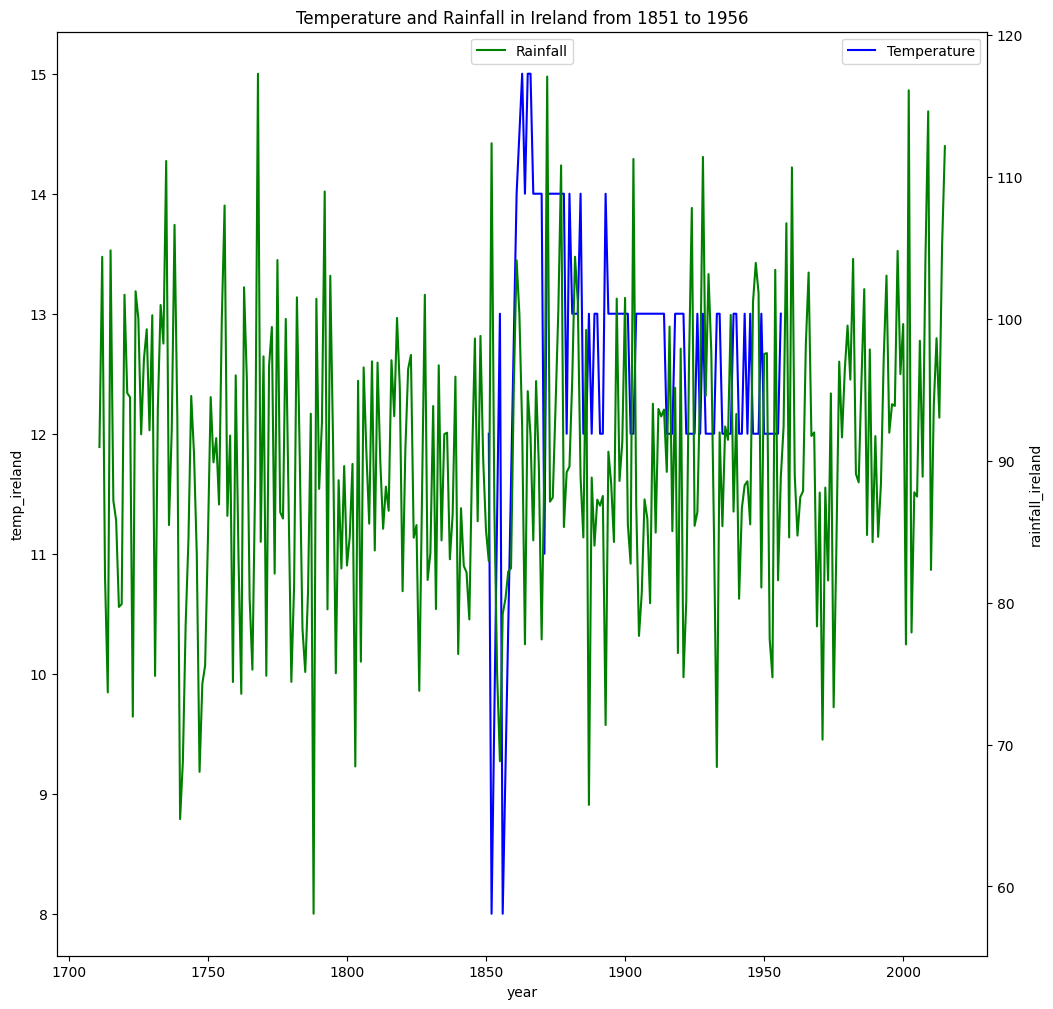

In [59]:
fig, ax = plt.subplots(figsize=(12,12))
sns.lineplot(x="year", y="temp_ireland", data=ireland_temp, color="b", label="Temperature")
ax2 = plt.twinx()
sns.lineplot(x="year", y="rainfall_ireland", data=ireland_rainfall, color="g", ax=ax2, label="Rainfall")
plt.title("Temperature and Rainfall in Ireland from 1851 to 1956")
plt.legend(loc='upper center');

### Temperature and CO2

In [27]:
epica = pd.read_csv('CSV Files\Epica Temp.csv', encoding='ISO-8859-1')
ipcc = pd.read_csv('CSV Files\IPCC CO2.csv')
nature = pd.read_csv('CSV Files/Nature CO2.csv', dtype={'year': int})

In [28]:
epica.year = epica.year.round()
ipcc["year"] = pd.to_numeric(ipcc["year"])
ipcc.year = ipcc.year.round()

epica = epica[['year', 'temp']]
ipcc = ipcc[['year', 'co2']]
nature = nature[['year', 'co2']]

In [32]:
nature["year"] = pd.to_numeric(nature["year"])
nature.year = nature.year.round()

In [30]:
epica['year'] = 1950 - epica['year']
ipcc['year'] = 1950 - ipcc['year']
nature['year'] = 1950 - nature['year']

In [31]:
combined_CO2 = pd.concat([ipcc, nature])
combined_CO2.sort_values(by=['year'], ascending=True)

temp_CO2 = pd.concat([epica.dropna(), combined_CO2.dropna()], ignore_index=True)
temp_CO2.sort_values(by=['year'], ascending=True);

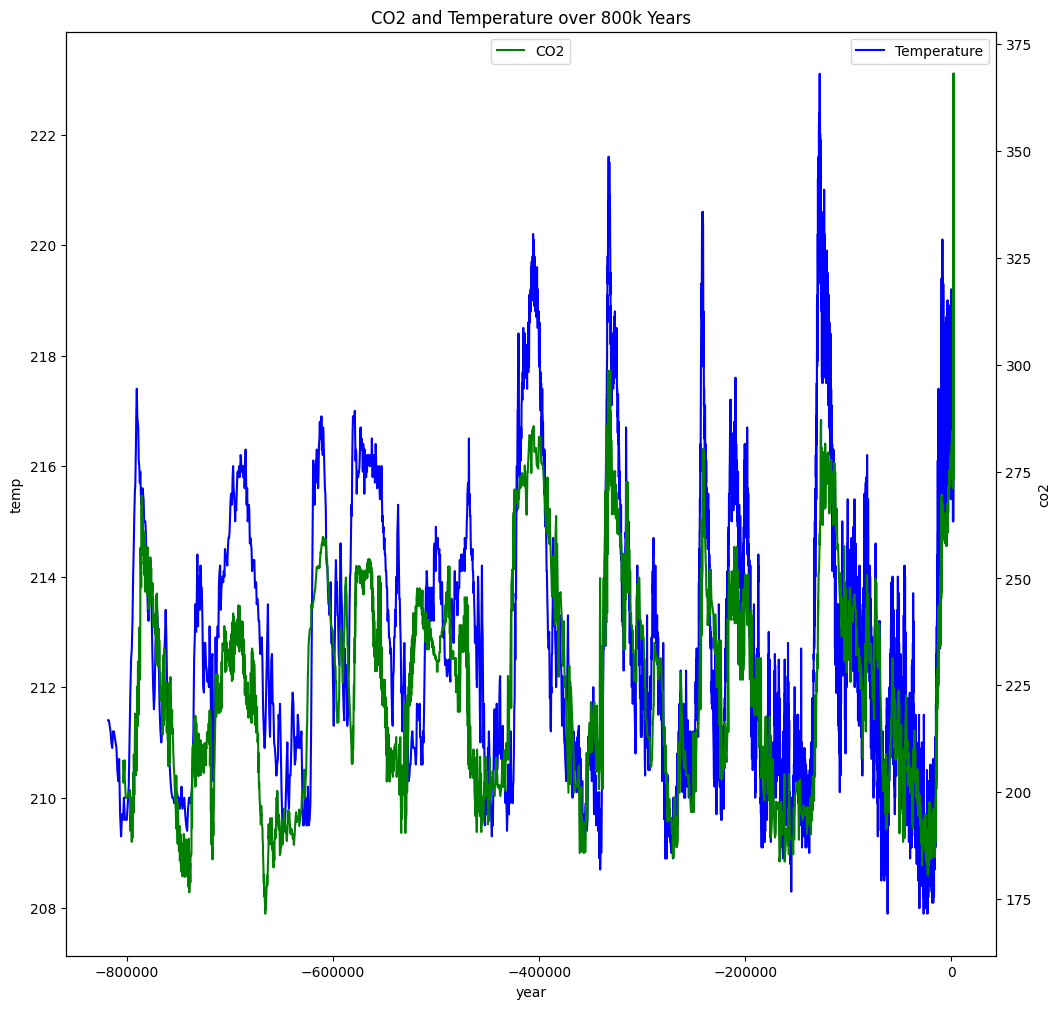

In [33]:
fig, ax = plt.subplots(figsize=(12,12))
sns.lineplot(x="year", y="temp", data=temp_CO2, color="b", label="Temperature")
ax2 = plt.twinx()
sns.lineplot(x="year", y="co2", data=temp_CO2, color="g", ax=ax2, label="CO2")
plt.title("CO2 and Temperature over 800k Years")
plt.legend(loc='upper center')

In [34]:
temp_present = pd.read_csv('CSV Files/temp 1958 to present.csv', encoding='ISO-8859-1', dtype={'year': int})
temp_present = temp_present[['year', 'temp']]

combined_temp = pd.concat([epica, temp_present])
combined_temp.sort_values(by=['year'], inplace=True, ascending=True);
combined_temp = combined_temp.astype({'year':'int'})

In [35]:
co2_present = pd.read_csv('CSV Files\co2_annmean_mlo.csv', encoding='ISO-8859-1', dtype={'year': int})
co2_present = co2_present[['year', 'co2']]

total_combined_co2 = pd.concat([combined_CO2, co2_present])
total_combined_co2.sort_values(by=['year'], inplace=True, ascending=True);
total_combined_co2 = total_combined_co2.astype({'year':'int'})

In [36]:
temp_CO2_present = combined_temp.merge(total_combined_co2, on='year', how='outer')
temp_CO2_present.sort_values(by=['year'], inplace=True, ascending=True);
temp_CO2_present = temp_CO2_present.astype({'year':'int'})

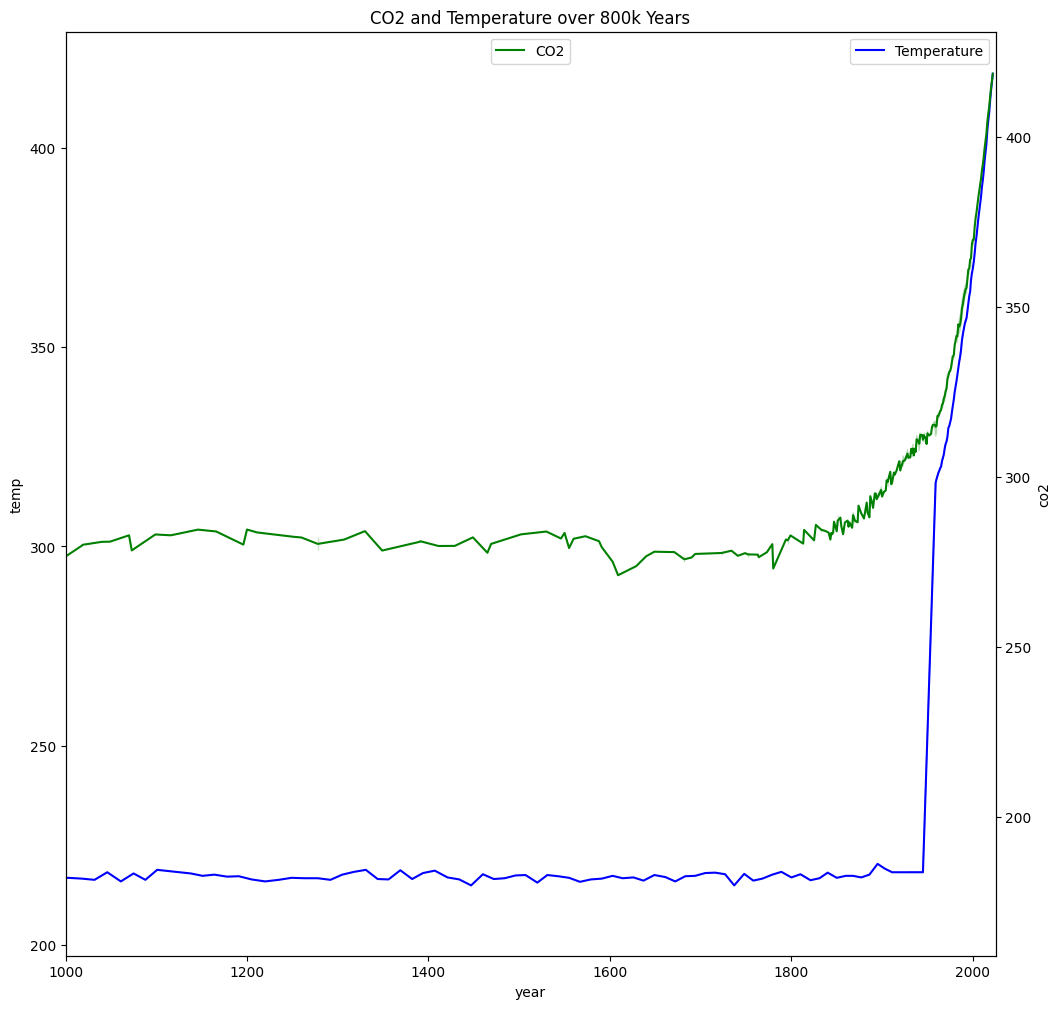

In [37]:
fig, ax1 = plt.subplots(figsize=(12,12))
ax2 = ax1.twinx()
sns.lineplot(x="year", y="temp", data=temp_CO2_present, color="b", ax=ax1, label="Temperature")
sns.lineplot(x="year", y="co2", data=temp_CO2_present, color="g", ax=ax2, label="CO2")
ax1.set_xlim(1000, 2025)
ax2.set_xlim(1000, 2025)
plt.title("CO2 and Temperature over 800k Years")
plt.legend(loc='upper center')

### Polar Ice

In [38]:
sea_ice = pd.read_csv('CSV Files\seaice.csv')

In [39]:
# We only take data from the northern hemisphere
northern = sea_ice[sea_ice.iloc[:,6]=='north']

In [40]:
# Save the list of the years
years_list = list(northern['Year'].value_counts().index)
years_list = sorted(years_list)

In [41]:
import warnings
warnings.simplefilter(action='ignore')
# Calcule monthly average of sea ice extent
def by_months(northern):    
    n_months = 3 + ((2019-1979) * 12) + 5 
    sea_ice_monthly = pd.DataFrame(columns=['Year', 'Month', 'Extent'], index=range(n_months))
    i = 0
    for year in years_list:
        
        if year == 1978:
            months_list = range(10,13)
        elif year == 2019:
            months_list = range(1,6)
        else:
            months_list = range(1,13)

        for month in months_list:
            subset = northern[northern['Year']==year][northern.iloc[:,1]==month]
            monthly_mean = np.mean(subset.iloc[:,3])
            sea_ice_monthly.iloc[i] = [year, month, monthly_mean]
            i += 1

    return sea_ice_monthly

sea_ice_clean = by_months(northern)

In [42]:
sea_ice_clean.head()

,Year,Month,Extent
0,1978,10,10.402667
1,1978,11,11.645133
2,1978,12,13.667063
3,1979,1,15.414
4,1979,2,16.175286


In [43]:
# Sort the dataset per month and year
sea_ice_clean = sea_ice_clean.sort_values(['Month', 'Year'])
sea_ice_clean = sea_ice_clean.reset_index().drop(['index'], axis=1)
sea_ice_clean.head()

,Year,Month,Extent
0,1979,1,15.414
1,1980,1,14.861875
2,1981,1,14.909688
3,1982,1,15.176733
4,1983,1,14.942438


In [44]:
mean_years = []
std_dict = {}
for m in range(1,13):
  #Calcule mu and std values
  mu = sea_ice_clean[sea_ice_clean.Month == m]['Extent'].mean()
  std = sea_ice_clean[sea_ice_clean.Month == m]['Extent'].std()
  #Save mu and std values
  mean_years.append(mu)
  std_dict[m] = std

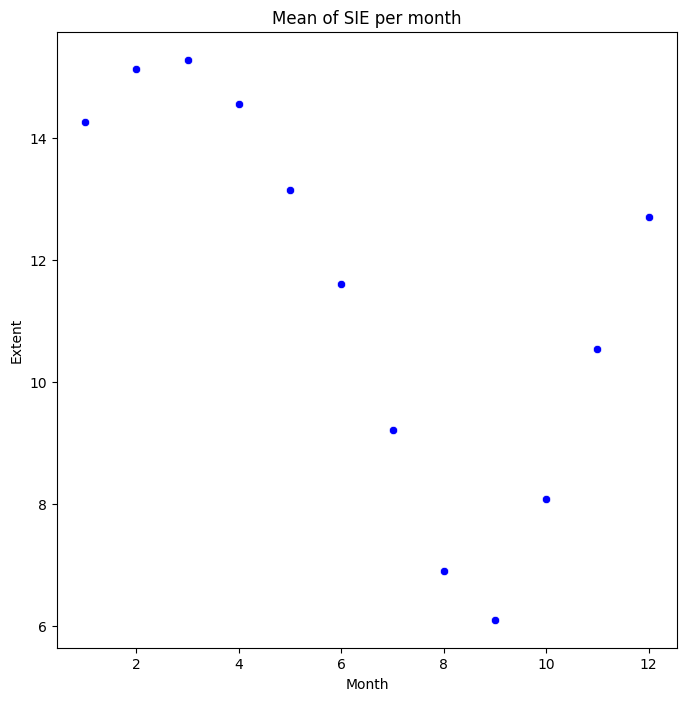

In [45]:
df_mean_years = pd.DataFrame(mean_years)
df_mean_years['Month'] = range(1, 13)
df_mean_years.columns = ['Extent', 'Month']
plt.figure(figsize=(8, 8))
sns.scatterplot(x='Month', y='Extent', data=df_mean_years,  color='blue', sizes=20).set(title='Mean of SIE per month')
plt.show()

In [46]:
#Compute Sea Ice Extent anomalies
def anomaliesSIE(sea_ice):
  #Calcule mean by months from 1981-2010
  df_30y = sea_ice.query('1981 <= Year <= 2010')
  df_30y = df_30y.reset_index().drop(['index'], axis=1)
  mean_30y = []
  for m in range(1,13):
    mu = sea_ice[sea_ice.Month == m]['Extent'].mean()
    mean_30y.append(mu)

  #Compute SIE anomalies
  anomalies_list = []
  for s in range(0, len(sea_ice)):
    mean_30y_index = sea_ice.loc[s, 'Month']-1
    #Calcule anomalies
    anomalies_SIE = sea_ice.loc[s, 'Extent'] - mean_30y[mean_30y_index]
    anomalies_SIE = anomalies_SIE/mean_30y[mean_30y_index]*100
    #Save anomalies
    anomalies_list.append(anomalies_SIE)
  sea_ice['AnomaliesSIE'] = anomalies_list
  return sea_ice, mean_30y

df_SIE, mean_30y = anomaliesSIE(sea_ice_clean)

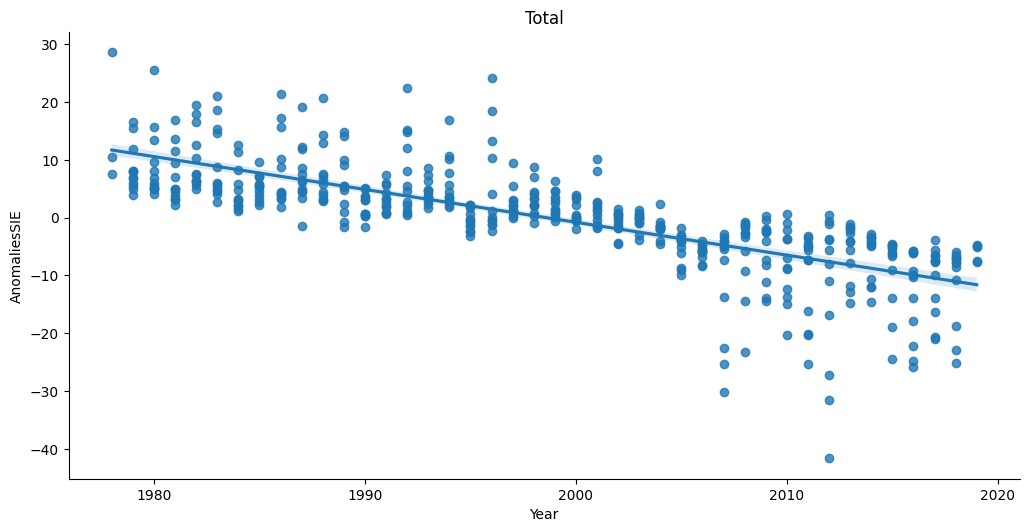

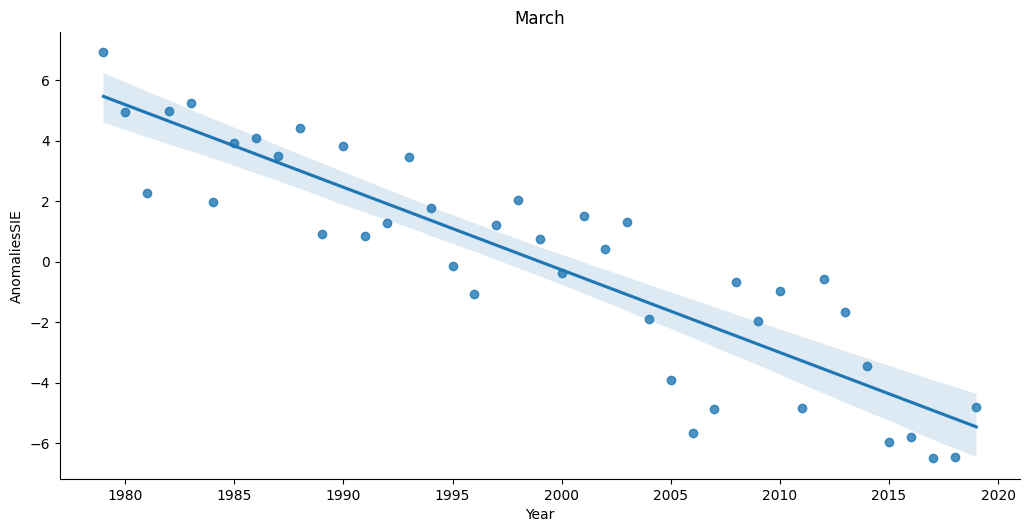

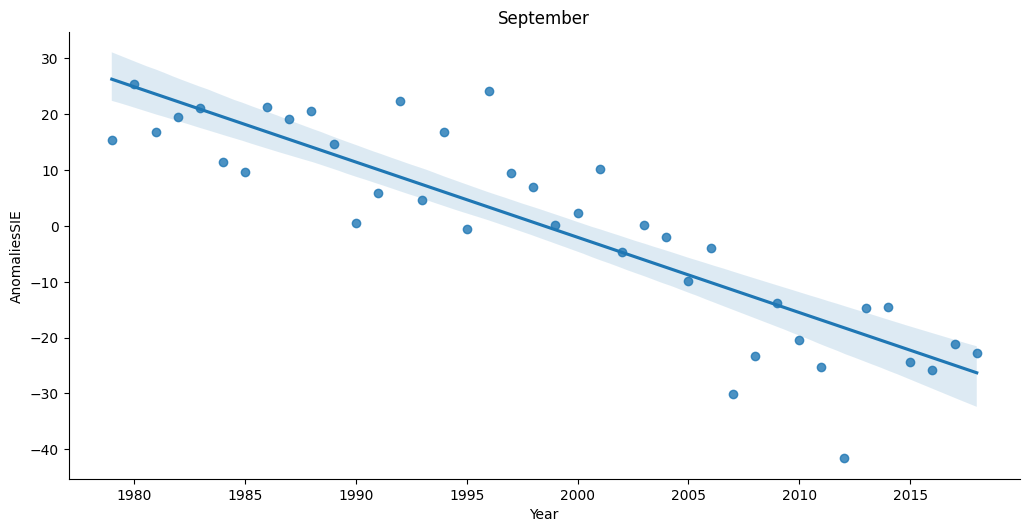

In [47]:
df_SIE['Year'] = pd.to_numeric(df_SIE['Year'])
#Total
sns.lmplot(x='Year', y='AnomaliesSIE', data=df_SIE, height=5.2, aspect=2).set(title='Total')
plt.show()
#January
sns.lmplot(x='Year', y='AnomaliesSIE', data=df_SIE[df_SIE.Month == 3], height=5.2, aspect=2).set(title='March')
plt.show()
#June
sns.lmplot(x='Year', y='AnomaliesSIE', data=df_SIE[df_SIE.Month == 9], height=5.2, aspect=2).set(title='September')
plt.show()

In [48]:
seaice_mean = []
std_dict = {}
for y in range(1978, 2019):
  #Calcule mu and std values
  mu = sea_ice_clean[sea_ice_clean.Year == y]['Extent'].mean()
  std = sea_ice_clean[sea_ice_clean.Year == y]['Extent'].std()
  #Save mu and std values
  seaice_mean.append(mu)
  std_dict[y] = std

seaice_mean;

In [54]:
years_seaice = list(range(1978, 2019));

df_seaice_mean = pd.DataFrame({'year': years_seaice, 'sea_ice': seaice_mean})
df_seaice_mean.sea_ice = df_seaice_mean.sea_ice.round(2)
df_seaice_mean.to_csv("df_seaice_mean.csv", encoding='utf-8', index=False)

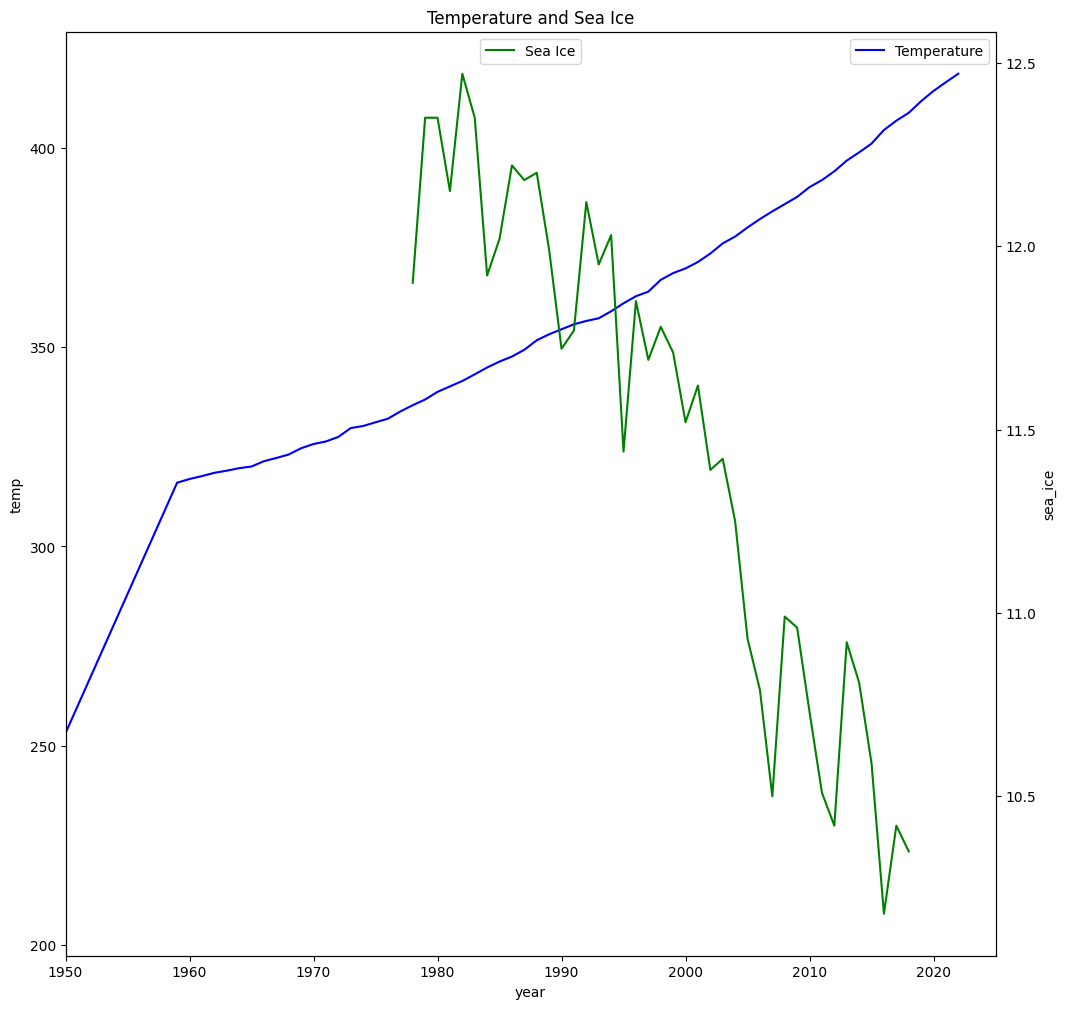

In [55]:
fig, ax1 = plt.subplots(figsize=(12,12))
ax2 = ax1.twinx()
sns.lineplot(x="year", y="temp", data=temp_CO2_present, color="b", ax=ax1, label="Temperature")
sns.lineplot(x="year", y="sea_ice", data=df_seaice_mean, color="g", ax=ax2, label="Sea Ice")
ax1.set_xlim(1950, 2025)
ax2.set_xlim(1950, 2025)
plt.title("Temperature and Sea Ice")
plt.legend(loc='upper center')

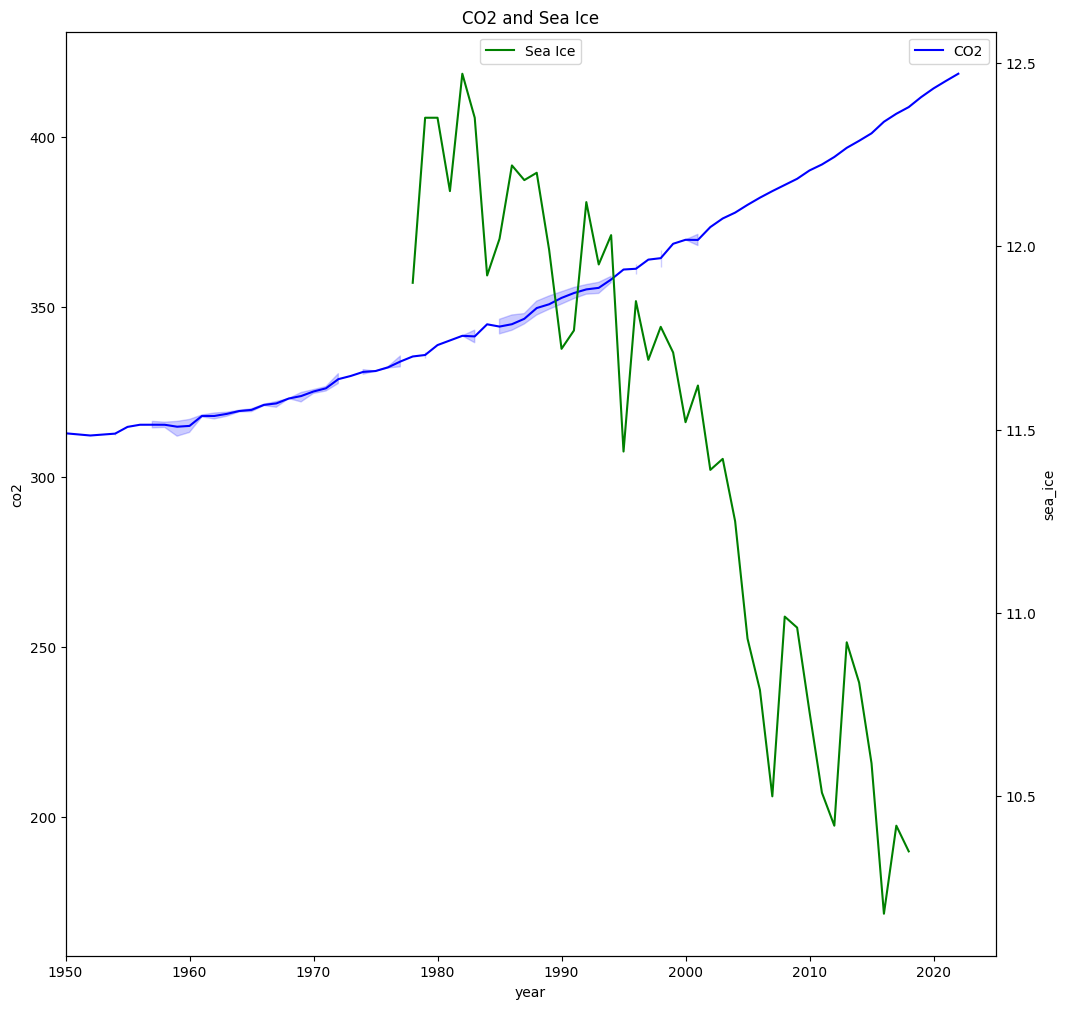

In [56]:
fig, ax1 = plt.subplots(figsize=(12,12))
ax2 = ax1.twinx()
sns.lineplot(x="year", y="co2", data=temp_CO2_present, color="b", ax=ax1, label="CO2")
sns.lineplot(x="year", y="sea_ice", data=df_seaice_mean, color="g", ax=ax2, label="Sea Ice")
ax1.set_xlim(1950, 2025)
ax2.set_xlim(1950, 2025)
plt.title("CO2 and Sea Ice")
plt.legend(loc='upper center')

## Combining Data into one Dataframe

In [60]:
combined_data = temp_CO2_present.merge(df_seaice_mean, on='year', how='outer').merge(ireland_temp, on='year', how='outer').merge(ireland_rainfall, on='year', how='outer')
combined_data.sort_values(by=['year'], inplace=True, ascending=True);
#temp_CO2_present = temp_CO2_present.astype({'year':'int'})
combined_data.to_csv('combined_data.csv', index=False)
combined_data.to_json('combined_data.json', orient='records', lines=False, indent=4)

In [63]:
combined_data.describe()

,year,temp,co2,sea_ice,temp_ireland,rainfall_ireland
count,8969.000000,5933.000000,3072.000000,67.000000,133.000000,406.000000
mean,-221477.734419,216.038001,236.815013,11.700597,12.699248,90.035936
std,231555.879715,19.042095,38.069440,0.615194,0.984616,9.928260
min,-818144.000000,207.900000,171.600000,10.180000,8.000000,58.080000
25%,-357455.000000,211.000000,206.395000,11.430000,12.000000,84.410000
50%,-126245.000000,213.000000,233.100000,11.920000,13.000000,89.135000
75%,-31274.000000,216.200000,258.100000,12.180000,13.000000,96.990000
max,2022.000000,418.530000,418.530000,12.470000,15.000000,117.280000


In [64]:
combined_data.dtypes

year                  int64
temp                float64
co2                 float64
sea_ice             float64
temp_ireland        float64
rainfall_ireland    float64
dtype: object

In [67]:
print('Correlation:')
combined_data.corr() 

Correlation:


,year,temp,co2,sea_ice,temp_ireland,rainfall_ireland
year,1.000000,0.131033,0.307039,-0.936080,-0.320754,0.127934
temp,0.131033,1.000000,0.906741,-0.948741,-0.438343,0.057857
co2,0.307039,0.906741,1.000000,-0.951331,-0.653027,0.267473
sea_ice,-0.936080,-0.948741,-0.951331,1.000000,NaN,-0.114438
temp_ireland,-0.320754,-0.438343,-0.653027,NaN,1.000000,-0.138450
rainfall_ireland,0.127934,0.057857,0.267473,-0.114438,-0.138450,1.000000


As already visualised with the line graphs plotted above, there is a high level of correlation between temperature and CO2 levels over the past 800 thousand years.

From the data displayed in the table above, the value of 0.91 for correlation between temperature and CO2 levels indicate the two variables are linearly related. This means they change together at a constant rate. A value of +1 or-1 indicates complete correlation, while a value of 0 indicates complete absence of correlation. The closer the correlation value is to 1, the greataer the correlation is between the variables.

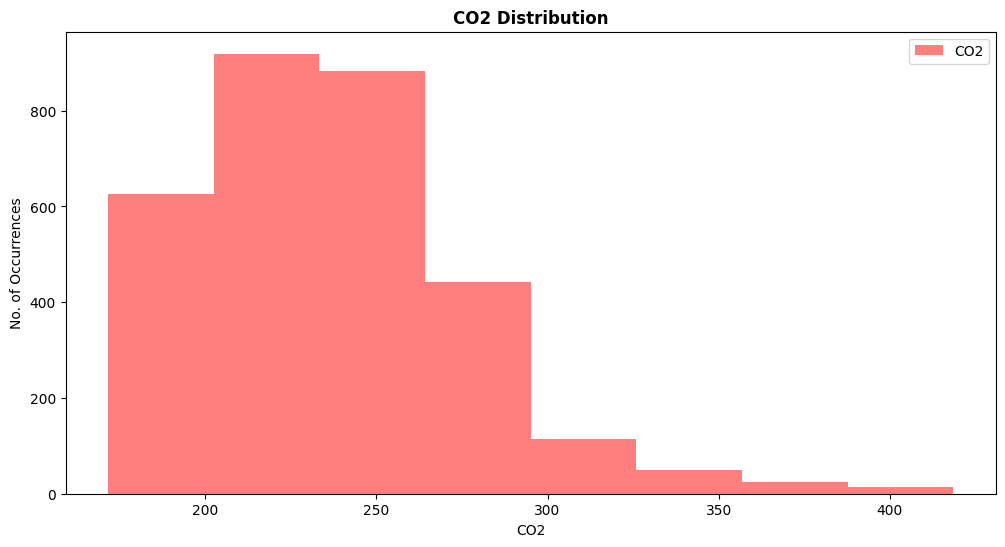

In [79]:
# Plot a Histogram for CO2 Distribution

fig, ax = plt.subplots(figsize = (12,6))

ax.set_title("CO2 Distribution", fontweight='bold') # to set the title of the plot
ax.set(xlabel='CO2')    # to set the x axis title
ax.set(ylabel="No. of Occurrences") # to set the y axis title
ax.hist(combined_data['co2'], bins=8, alpha=0.5, label="CO2", color='red')  # to plot a histogram of CO2 distribution
ax.legend(loc='upper right'); # to place the legend of the plot in the upper right

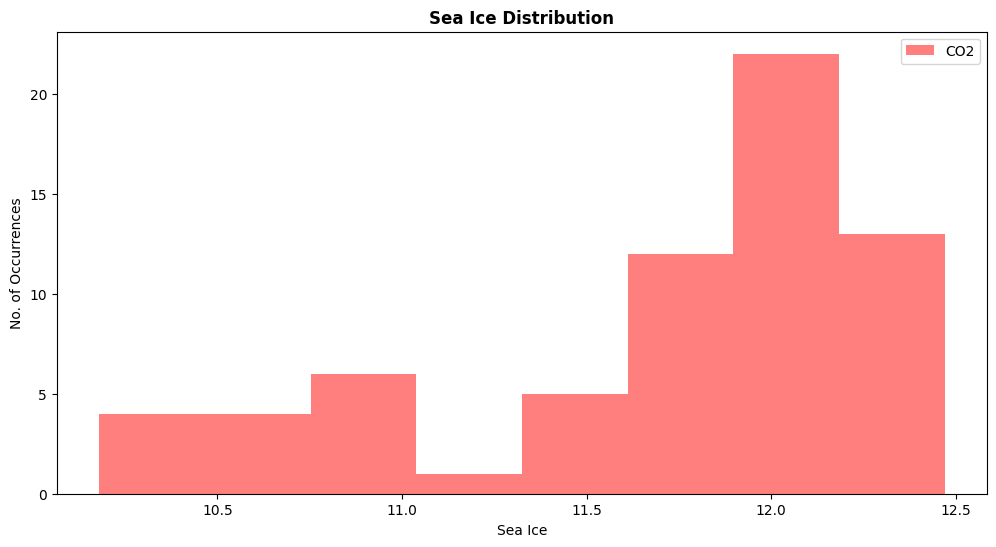

In [80]:
# Plot a Histogram for Sea Ice Distribution

fig, ax = plt.subplots(figsize = (12,6))

ax.set_title("Sea Ice Distribution", fontweight='bold') # to set the title of the plot
ax.set(xlabel='Sea Ice')    # to set the x axis title
ax.set(ylabel="No. of Occurrences") # to set the y axis title
ax.hist(combined_data['sea_ice'], bins=8, alpha=0.5, label="CO2", color='red')  # to plot a histogram of sea ice distribution
ax.legend(loc='upper right'); # to place the legend of the plot in the upper right

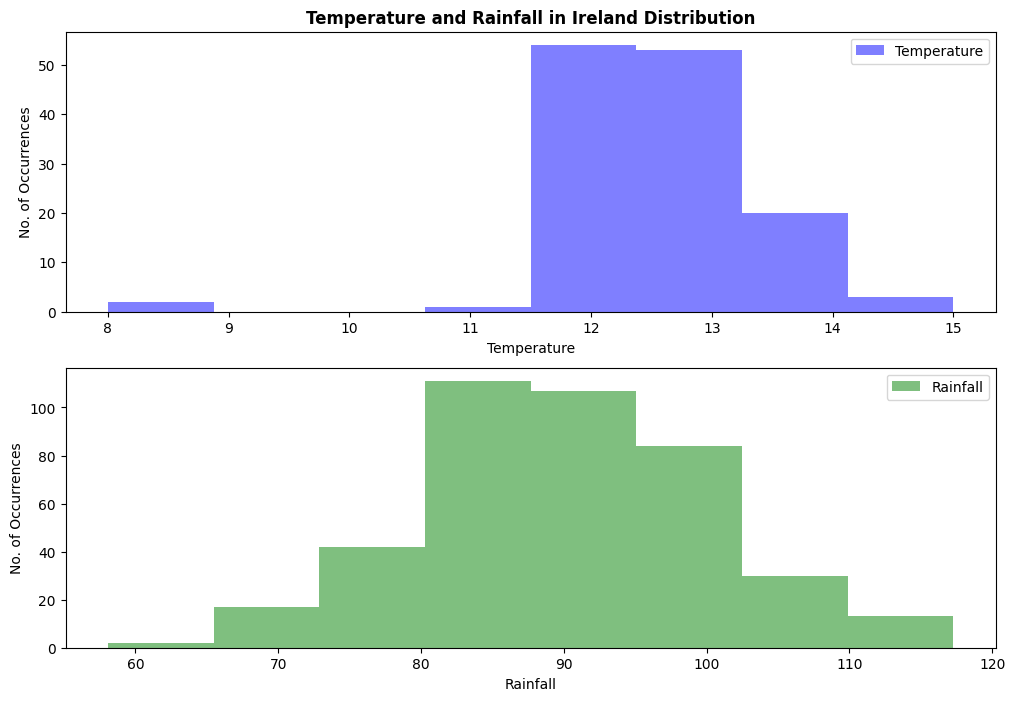

In [78]:
# Plot a Histogram for Temperature and Rainfall in Ireland Distribution

fig, axes = plt.subplots(2, figsize = (12,8))  # to create two vertically stacked subplots

axes[0].set_title("Temperature and Rainfall in Ireland Distribution", fontweight='bold')
axes[0].set(xlabel='Temperature')
axes[0].set(ylabel="No. of Occurrences")
axes[0].hist(combined_data['temp_ireland'], bins=8, alpha=0.5, label="Temperature", color='blue')
axes[0].legend(loc='upper right')

axes[1].set(xlabel='Rainfall')
axes[1].set(ylabel="No. of Occurrences")
axes[1].hist(combined_data['rainfall_ireland'], bins=8, alpha=0.5, label="Rainfall", color='green')
axes[1].legend(loc='upper right')

epica dc determined CO2 and temperature data from ice cores - the temperature is inferred from the isotopic composition of the water molecules released by melting the ice cores.

For this reason, it is difficult to compare the temperature data collected for Ireland to the over 800 thousand years of data collected worldwide.
I have searched online for ways to compare this data to degrees Celsius, however I havent been able to find anything concrete on this matter.

https://www.scientificamerican.com/article/how-are-past-temperatures/

In [86]:
combined_2 = combined_data[['temp', 'co2', 'sea_ice', 'temp_ireland', 'rainfall_ireland']]

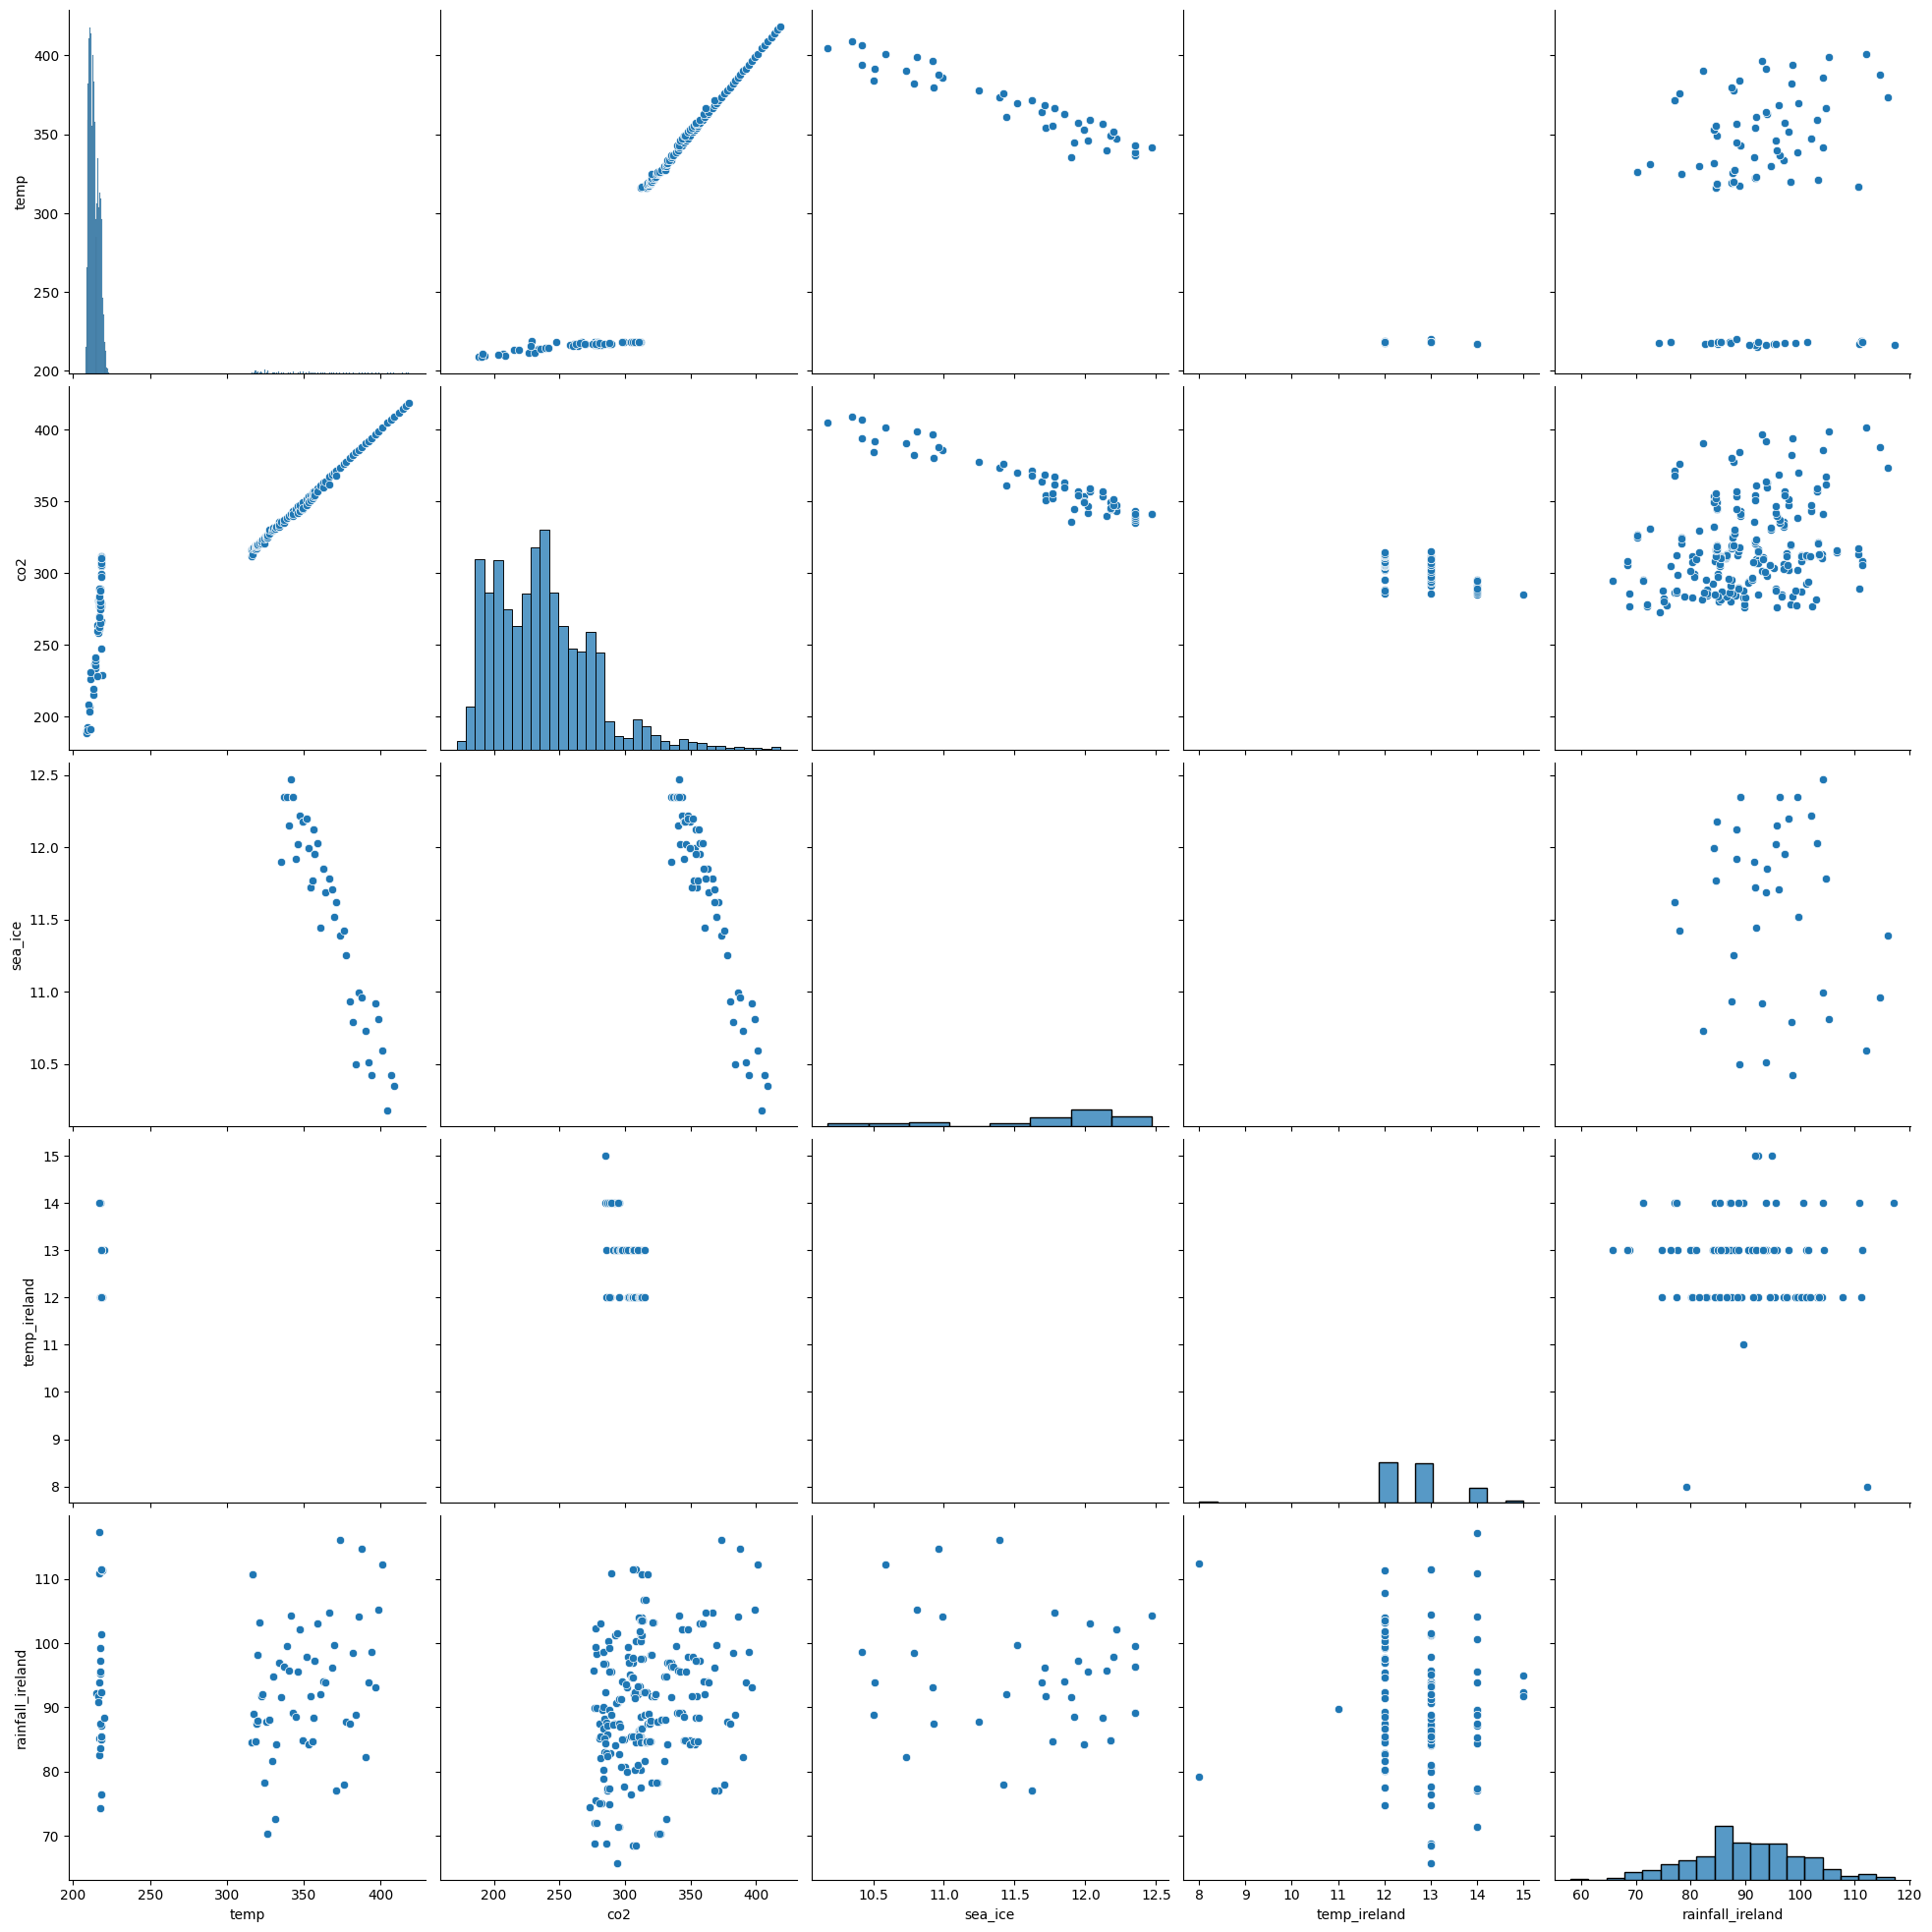

In [89]:
# a pairplot using the seaborn module, to display distributions of the variables in the dataset
sns.pairplot(combined_2, height=4, palette=['blue', 'purple', 'blueviolet'])

Text(0.5, 1.0, 'Boxplots of Measuring Variables')

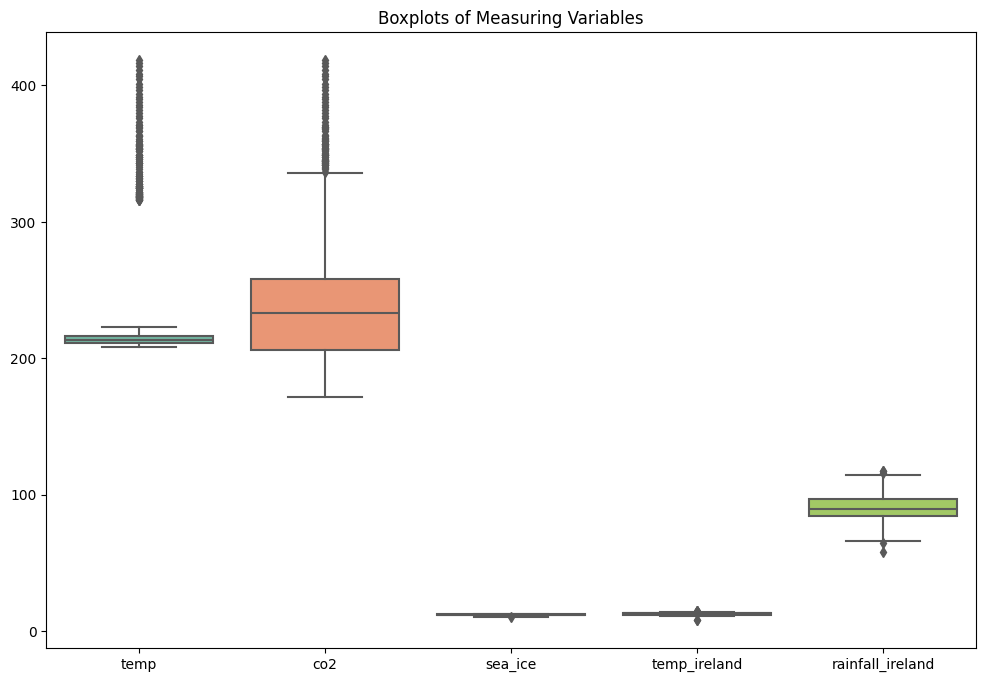

In [94]:
# plotting a boxplot of temperature and CO2

fig, ax = plt.subplots(figsize=(12,8))
ax = sns.boxplot(data=combined_2, orient="v", palette="Set2")  # to create a boxplot using seaborn of the variables age and training hours, categorised by sex
ax.set_title("Boxplots of Measuring Variables")
# https://stackoverflow.com/questions/66833728/boxplots-with-seaborn-for-all-variables-in-a-dataset-at-once